# REPORT
## Predicting customer churn


**Brief overview**
In this project, we are building a model for a telecom operator, Niedinogorazryva.com, who wants to predict customer churn. Since attracting a new client is expensive, if it turns out that the user plans to leave, he will be offered promotional codes and special discounts.

We have personal data about some clients, information about their tariffs and contracts.

**Project goal**: Build a model with a predictive power in terms of the ROC-AUC metric of at least 0.85

We have personal data about some clients, information about their tariffs and contracts.

**Overview of the services**

The operator provides two main types of services:

1. Fixed telephone connection. It is possible to connect a telephone set to several lines at the same time.
2. Internet. The connection can be of two types: via a telephone line (DSL *, * from the English * digital subscriber line *, "digital subscriber line") or fiber optic cable (* Fiber optic *). 

The following services are also available:

- Internet security: antivirus (*DeviceProtection*) and blocking of unsafe sites (*OnlineSecurity*);
- Dedicated technical support line (*TechSupport*);
- Cloud file storage for data backup (*OnlineBackup*);
- Streaming TV (*StreamingTV*) and movie catalog (*StreamingMovies*).

Clients can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic check are available


**What do we do?**

1. Open the data and do the primary research (EDA)
     - Fill in the gaps, check the correctness of types, remove duplicates
     - We study the data, do the initial analytics, build graphs of the distribution of individual variables and the correlation matrix
3. Divide into test and training samples (0.25 / 0.75)
4. Create additional features, make a preprocessor
     - Analyze for multicollinearity, feature selection
4. Train multiple models
     - Logistic regression, random forest, gradient boosting
     - We carry out a selection of hyperparameters using cross-validation
6. We select models according to the ROC-AUC metric (at least 0.85)
7. Feature Importance Analysis
8. Final conclusions
     - Recommend the model to be used by the client
     - Making other recommendations on observations from the data
    
## EDA

* We have 7043 customer data samples. At the same time, not all clients use all services, since there are 6361 data on telephone contracts, and 5517 Internet
* We do not see any obvious gaps in the data
* For analysis, we need a target feature that we create - whether the client terminated the contract or not:
     * 1 yes, terminated
     * 0 no, not terminated


### Merging tables, filling gaps, changing data types
* The data structure is quite linear - everything is merged by the customer_id key, so we merge tables by this key
   
- We filled in the gaps:

     * From the data, information was lost which contract each client has - Internet or phone.
     * By internet, by the connection type column - we will add "no_internet" instead of empty values, so we will recover information - who has internet and who doesn't.
     * Do the same on the phone (no_telephone)
     * For services, fill in No in case of empty cells - this means that the service is not provided
    
**Data type change**

* We also noticed the wrong type for total_charges because it contains empty strings as a space ' '
* Since there are only 11 such lines, we suggest simply deleting them

### Data analysis

* We have added a feature for how long the contract was opened - `client_years`
* We see that the distribution is similar to bimodal - many new clients and many old clients who are about 6 years old

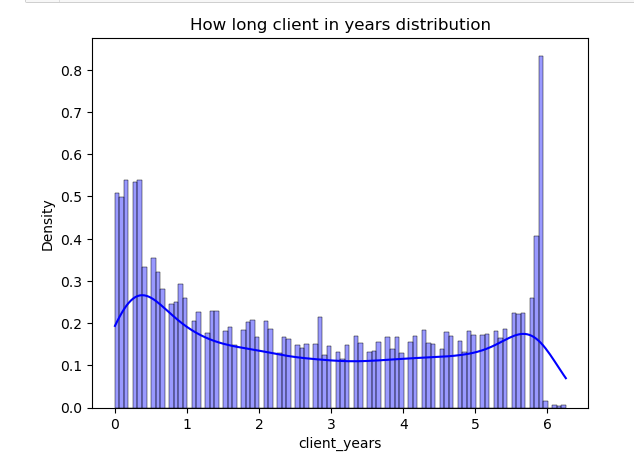

### Target correlation with variables:
* Constructed a correlation matrix of target phik with other values.
* We also indicate the stat significance. Stat significance for fi correlation works differently, it shows the number of standard deviations and small values indicate insignificance, and high values vice versa:
     - Only gender, the presence of a telephone or lines did not become significant. (compare with 5 standard deviations)
    
**We observe a linear dependence of the average force (0.3-0.5)**:
- `paperless_billing`, `payment_method` Those who use electronic billing leave the company more often, perhaps these people use the Internet more often to compare prices, for example, with competitors
- `client_years`, `total_charges` - older clients leave less often, so they accumulate more total_charges
- `monthly_charges` - shows the presence of a dependency, it is more difficult to guess with a dependency sign
    
Other coefficients are too low or not significant

### Correlation matrix

* We also explored linear dependencies between predicates using the correlation matrix phik
     * `monthly_charges` - linearly dependent on additional services such as online_backup, streaming services. High dependence on the type of Internet
     * `total_charges` - also dependent on additional services, there is a dependence on how long they have been clients
     * `internet_serivice` - high dependency on phone and lines
     * `device_protection`, `tech_support` and other services have a linear relationship of medium strength
* All dependencies above stat are significant

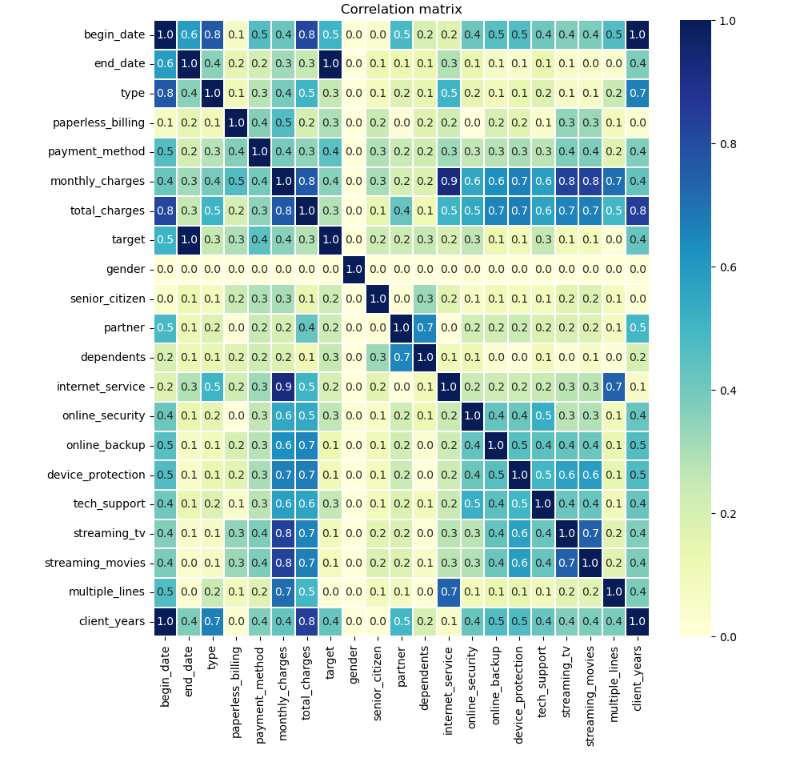


**Target depends on the type of phone or Internet service**:
- We see that, on average, the target does not change much from the presence of a phone or several lines (about 0.25)
- **However, the fiber target is much higher than the 0.42 dataset**, this may indicate that the quality of the fiber is not the best, and companies should pay attention to this

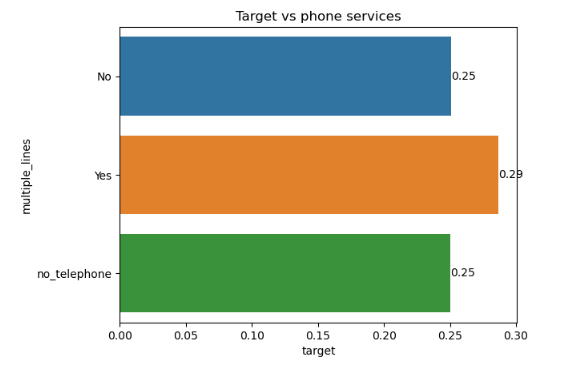
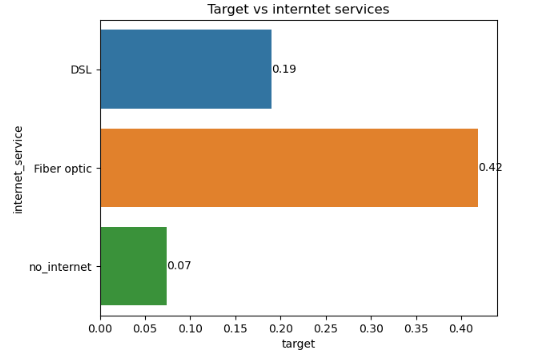

### Portrait of an churned client

**Portrait of an exiting client from initial data analysis helped focus further research and facilitate feature selection**

* They pay a higher monthly fee
* They have less total payouts by more than twice the median
*Use optical fiber
* Have been a customer for less than 1 year

## Dealing with class imbalance

- In our case, there is an imbalance of classes but not pronounced (1 to 3). In addition, the metric is ROC-AUC, this metric is sensitive to class imbalance in the sense that guessing the correct values of a rarer class has a large weight, in contrast to accuracy, where the weight is the same. Therefore, we consider the choice of metric to be successful in this exercise.
- We will also use built-in balancing methods in algorithms using class weights

## Feature engineering and selection


### Feature engineering
* In order to improve the quality of the model, we have added several features that, in our opinion, could help with the explanation of the target
     1. `monthly_total_ratio` How much the client pays per month / average per month of the total amount
         * Clients for whom this value is lower buy additional services and most likely close contracts less often
     2. `total_per_person` how much was spent / an estimate of the number of family (1 - one, 2 - partner, 3 - partner and dependent)
         * This estimate better shows the real costs per person under the contract. The entire household uses the Internet and telephone
     3. `monthly_per_person` payment per month / estimated number of family (1 - one, 2 - partner, 3 - partner and dependent)
         * Same logic as above, but for a month
     4. `last_year_payment` How much the client paid in the last 12 months based on full payment
         * Those who paid more in the last 12 months used the company's services more actively. This statistic helps distinguish between old customers (active in the distant past or now)

### VIF selection

**Check for multicollinearity**:

* We use the Variance Inflation Factor method, we calculate the VIF for each numerical predictor in the model.

We use the following conventional interpretation:

  - VIF = 1: No correlation between predictor and other traits
  - VIF between 1 and 5: there is little correlation between predictor and other traits
  - VIF > 5: Strong correlation between predictor and other traits

**Multicollinearity problem**
  * We note the problem of data multicollinearity in the dataset, first of all, it is due to the fact that in the original dataset there are only 2 numeric variables (full payment and per month), which are obviously related to each other.
* We created several features, but they were all correlated, after removing the feature, we are left with two that show a low degree of correlation.
* Final characteristics are the time (years) from the beginning of the contract and the ratio of the monthly payment to the final one, `client_years`, `monthly_total_ratio`.

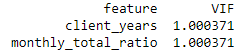

## Encoding variables and creating a preprocessing pipeline

* We create preprocessing, it is built from
     1. For numerical features:
         1. Creation of features
         2. Standard scaler
     2. For categorical features:
          1. For feature coding we will use One-hot as we don't have many categories of each categorical variable (max 3)
         
## Training and selection of models

* We have chosen three classification models:
     1. Logistic regression
     2. Random Forest
     3. Gradient boosting (katboost)
* We work with class balance using built-in methods inside models for balancing
* The evaluation metric was ROC-AUC, this metric is sensitive to class imbalance in the sense that guessing the correct values of a rarer class is heavily weighted, unlike accuracy, where the weight is the same. Therefore, we consider the choice of metric to be successful in this exercise.
* Calibration of hyperparameters is done using gridsearch and cross-validation on 5 folds

### Best hyperparameters for models

1. Logistic regression:
- `C`: 3.5
- `class_weight`: balanced
- `solver`: lbfgs

2. Random Forest
- `class_weight`: None
- `max_depth`: 10
- `n_estimators`: 400

3 Catboost
- `class_weights`: SqrtBalanced
- `depth`: 4
- `iterations`: 700
- `learning_rate`: 0.07

### Model selection
* Gradient boosting performed best of 0.96 ROC-AUC on cross-validation, which is above the required thrashhold of 0.85
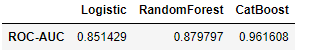

## Feature importances

* We analyzed the significance of features using the built-in catboost methods, which work on the basis of premutation and track the change in the loss function.

The top 2 features are numeric features:
- `monthly_total_ratio` the ratio of the regular monthly payment to the total monthly payment. Here we believe that if the client gets more additional services, then he has less motivation to close the contract.
- `client_years` how long ago the contract was made. As we saw earlier - the longer the client keeps the contract, the less often he leaves it. Since we have data on exits from the contract for the last 4 months, we believe that this value is approximately equal to how many times the client has been a client



<h4><center>Top 10</center></h4>


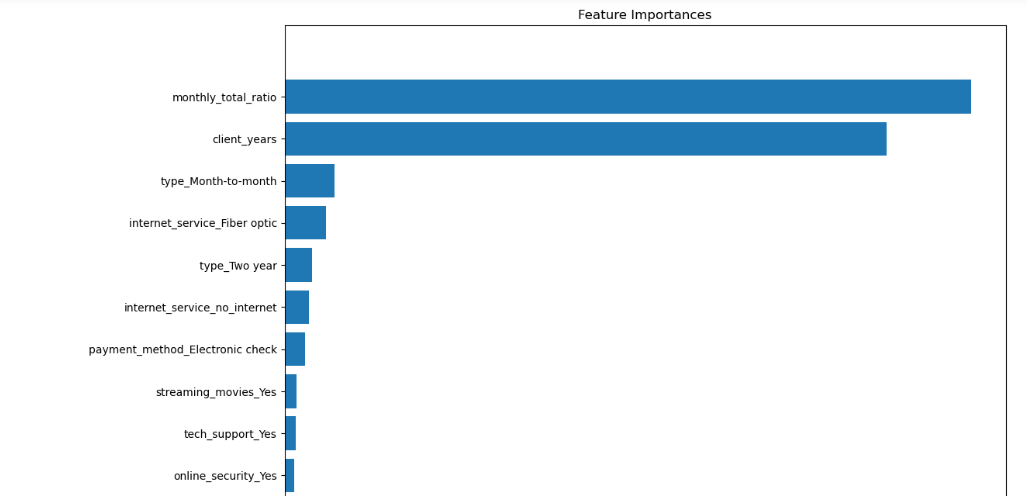

## Additional score metrics

* For clarity, we have built an error matrix and additional metrics

* According to the error matrix and additional metrics, we see that the model does a good job with both precision and recall, while the precision is higher, which means the model is not particularly mistaken in determining single classes

* Our recommendation for further work is to select a model that optimizes the recall metric - if we want to find exactly all customers who are going to terminate the contract

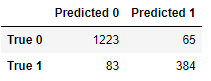


* `Accuracy score`: 0.92
* `Precision score`: 0.86
* `Recall score`: 0.82
* `F1 score`: 0.84


<h4><center>ROC-AUC</center></h4>


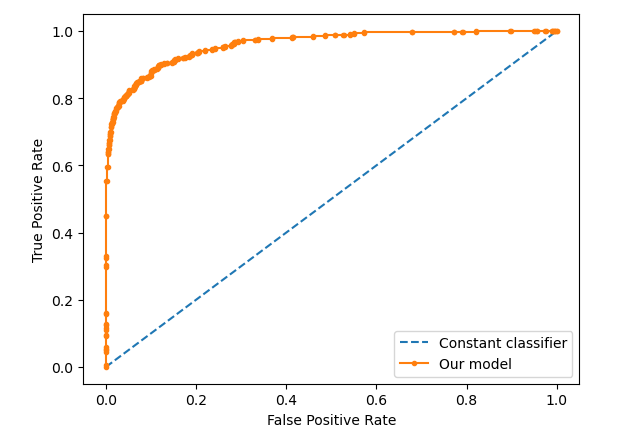


## Test set predictions

* On the test sample, the result is 0.96, which is higher than the prog metric and coincides with the validation. We consider the model successful.

## General conclusions

**In this work, we analyzed the data and developed a model for No Gap.com that predicts which customers are most likely to leave a contract and allows the marketing department to focus on retaining those customers**


**It was done according to plan, but there were difficulties**
* The work was done according to the original plan, but we encountered difficulties - the main problem was the multicollinearity of numerical variables and their small number (only two). It can resolve and improve the model if additional data is provided

**Which customers should the marketing department focus on**
*On those provided by the model, but analysis has shown that clients who have been clients for less than a year are more likely to terminate contracts. As well as customers who pay higher monthly commissions.

**Further work and data recommendations:**
- Data on terminations of contracts only for the last 4 months. Check that there is no error and expand the sample for a large number of months
- We also recommend expanding the data on clients and adding at least the age of the client, perhaps his address, because if the client uses a phone, the connection in his area may not be so good and people leave a certain area
* Our recommendation for further work is to select a model that optimizes the recall metric - if we want to find exactly all customers who are going to terminate the contract

**Total, we have developed a successful model for the company and important insights from data analysis that will help retain customers and earn money. Further research and improvement of the model is possible upon receipt of additional data indicated above**

# Исследование и код

## Загрузка данных

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.



In [1]:
# !pip install -q skimpy
# !pip install -q phik

In [3]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import catboost
import re
import skimpy
import phik

from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
from functools import reduce
from matplotlib import pyplot




from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv



pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

In [3]:
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    df_contract = pd.read_csv('contract.csv')
    df_internet = pd.read_csv('internet.csv')
    df_personal = pd.read_csv('personal.csv')
    df_phone = pd.read_csv('phone.csv')

## EDA

* Для начала приводим названия столбцов в snake case для удобства

In [7]:
df_contract = skimpy.clean_columns(df_contract)
df_internet = skimpy.clean_columns(df_internet)
df_personal = skimpy.clean_columns(df_personal)
df_phone = skimpy.clean_columns(df_phone)

8 column names have been cleaned

8 column names have been cleaned

4 column names have been cleaned

2 column names have been cleaned

In [8]:
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [9]:
for data in data_list:
    display(data.head(5), data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


None

* Описание колонок:
    - **`df_contract`**:
        - `customer_id` ID клиента
        - `begin_date` дата начала контракта
        - `end_date` дата конца конкракта, *No* - если контракт не окончен на конктрольную дату
        - `type` - тип оплаты - периодичность обновления подписки, 'Month-to-month', 'One year', 'Two year'
        - `paperless_billing` - *Yes*, если клиенту не приходят чеки на почту
        - `payment_method` - метод оплаты
        - `monthly_charges` - сколько платит помесячно
        - `total_charges` - сколько заплатил всего за время существования контракта
    - **`df_internet`**:
        - `customer_id` ID клиента
        - `internet_service` - тип подключения 'DSL', 'Fiber optic'
        - `online_security`, `online_backup`,`device_protection`, `tech_support`, `streaming_t_v`, `streaming_movies` - различные дополнительные сервисы (булевые величины)
    - **`df_phone`**:
        - `customer_id` ID клиента
        - `multiple_lines` - есть ли несколько линий или нет
    - **`df_personal`**:
        - `customer_id` ID клиента
        - `gender` - гендер
        - `senior_citizen` - пенсионер
        - `partner` - состоит ли в браке
        - `dependents` - наличие иждивенцев

* У нас имеется 7043 данных о клиентах. При этом не все клиенты пользуются всеми сервисами, так как данных о телефонных контрактах  6361, а интерент 5517
* Наличие очевидных пропусков в данных мы не видим
* Для анализа нам понадобится целевой признак - рассторгнул ли клиент контракт или нет:
    * 1 да, рассторгнул
    * 0 нет, не рассторгнул

In [10]:
df_contract['target'] = (df_contract.end_date != 'No').astype(int)
df_contract.target.describe()

count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

* Мы видим, что 27% рассторгнуло контракт, мы имеем дело с дисбалансом классов нашей классификационной задаче

* Структура данных довольно линейная - все мержится по ключу customer_id, поэтому предлагаем сразу смержить таблицы, чтобы было удобнее с ними работать. Мержим по таблице с конрактами, чтобы ни один контракт не пропал

### Объединение таблиц

In [11]:
dfs =[df_contract, df_personal, df_internet, df_phone]

df = reduce(lambda  left,right: pd.merge(left,right,on=['customer_id'],
                                            how='outer'), dfs)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   target             7043 non-null   int32  
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   int64  
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

### Заполнение пропусков

- Мы получили ожидаемый результат от объединения таблиц, там необходимо заполнить пропуски, где они есть - это в предоставляемых услугах:

    * Из данных потерялась информация какой конракт имеет каждый клиент - интренет или телефон. 
    * По интернету, по колонке тип соединения - мы добавим "no_internet" вместо пустых значений, таким образом мы восстановим информацию - у кого есть интернет, а у кого его нет.
    * По телефону делаем тоже самое (no_telephone)
    * По услугам заполняем No в случае пустых клеток - это означает, что услуга не предоставляется

In [13]:
df.loc[df.internet_service.isna(),'internet_service'] = 'no_internet'
df.loc[df.multiple_lines.isna(),'multiple_lines'] = 'no_telephone'

In [14]:
df.multiple_lines.value_counts()

No              3390
Yes             2971
no_telephone     682
Name: multiple_lines, dtype: int64

In [15]:
df.internet_service.value_counts()

Fiber optic    3096
DSL            2421
no_internet    1526
Name: internet_service, dtype: int64

In [16]:
df.fillna('No', inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   target             7043 non-null   int32  
 9   gender             7043 non-null   object 
 10  senior_citizen     7043 non-null   int64  
 11  partner            7043 non-null   object 
 12  dependents         7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

* Пропуски устранены
* На всякий случай проверим на явные дубликаты:

In [18]:
df.set_index('customer_id', drop=True, inplace=True)

In [19]:
df.duplicated().sum()

13

In [20]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### Изменение типов данных

* Мы также заметили неверный тип для total_charges, потому что он содержит пустые строки в виде пробела ' '
* Так как таких строк всего 11, предлагаем им просто удалить

In [21]:
(df.total_charges == ' ').sum()

11

In [22]:
df.drop(df.loc[df.total_charges == ' '].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [23]:
df.shape

(7019, 20)

* Меняем тип данных

In [24]:
#dates
df.begin_date = pd.to_datetime(df.begin_date)
df.loc[df.target == 1, 'end_date'] = pd.to_datetime(df.loc[df.target == 1, 'end_date'])

#total charges
df.total_charges = df.total_charges.astype(float)

In [25]:
df.loc[df.senior_citizen == 1, 'senior_citizen'] = 'Yes'
df.loc[df.senior_citizen == 0, 'senior_citizen'] = 'No'

In [26]:
df.select_dtypes(object).nunique()

end_date             5
type                 3
paperless_billing    2
payment_method       4
gender               2
senior_citizen       2
partner              2
dependents           2
internet_service     3
online_security      2
online_backup        2
device_protection    2
tech_support         2
streaming_tv         2
streaming_movies     2
multiple_lines       3
dtype: int64

* С изменением типа данных справились, другие данные будут закодированы далее, как категориальные
* Сразу замечаем, что количество категорий не такое большое - максимум 4, поэтому подойдет One-hot-encoding
* Кажется странным, что у нас на конец контракта приходится всего 4 даты - т.е. данные у нас по окончанию контрактов за последние 4 месяца.
* **Рекомендация к данным:** Данные по расторжениям контрактов за последние 4 месяца. Проверить, что там нет ошибки и расширить выборку за большое количестов месяцев
* Также данные по клиентам какие-то скудные - нужно бы добавить как минимум еще возраст клиента, возможно, его адрес, так как если клиент использует телефон, может коннекшен в его районе не такой хороший и люди уходят из определенного района

In [27]:
print(df.end_date.unique())
print(df_contract.end_date.unique())

['No' Timestamp('2019-12-01 00:00:00') Timestamp('2019-11-01 00:00:00')
 Timestamp('2019-10-01 00:00:00') Timestamp('2020-01-01 00:00:00')]
['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']


### Первичный анализ данных

* Добавим колонку как давно они являются клиентом в годах
* Мы видим что распределение похоже на бимодальное - много новых клиентов и много старых клиентов, которые около 6 лет

In [28]:
max_date = pd.Timestamp('2020-01-01')
df['client_years'] = (max_date - df.begin_date).dt.days / 365

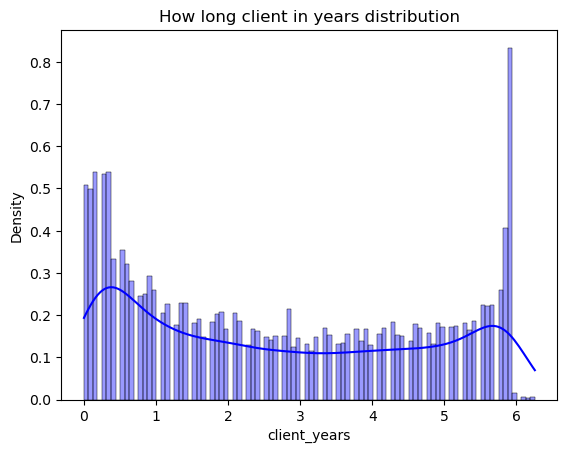

In [29]:
sns.histplot(df.client_years, kde=True, alpha = 0.4, color = 'blue', stat= 'density', bins=100)
plt.title('How long client in years distribution')
plt.show()

* Рассмотрим как распределены месячный и полные выплаты
* Распределение сильно скошено к нулю, т.е большинство клиентов платят мало

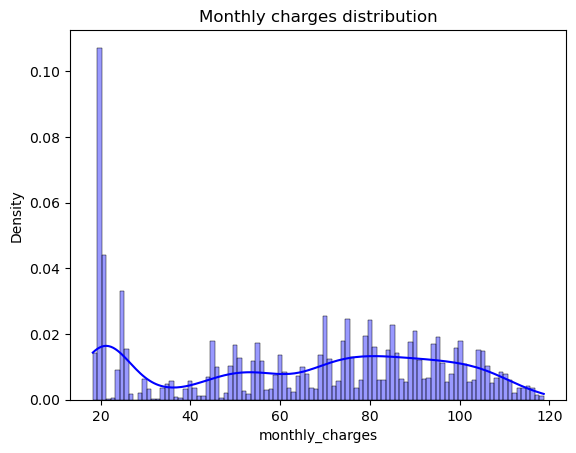

In [30]:
sns.histplot(df.monthly_charges, kde=True, alpha = 0.4, color = 'blue', stat= 'density', bins=100)
plt.title('Monthly charges distribution')
plt.show()

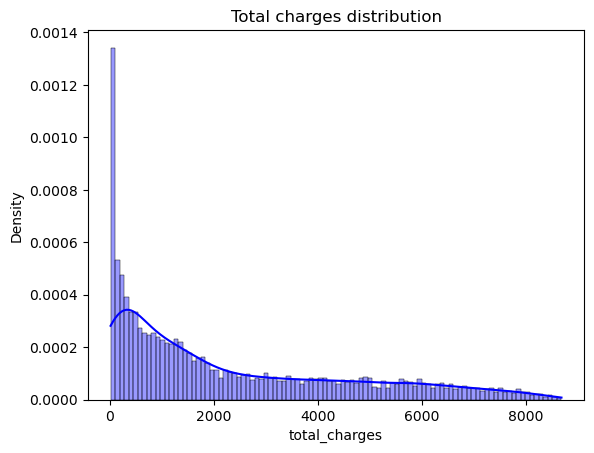

In [31]:
sns.histplot(df.total_charges, kde=True, alpha = 0.4, color = 'blue', stat= 'density', bins=100)
plt.title('Total charges distribution')
plt.show()

### Корреляция таргета с переменными:
* Построим корреляцияонную матрицу таргета phik с другими значениями.
* Также укажем стат значимость. Стат значимость для фи корреляция работает по другому, она показывает количество стандартных отклонений и маленькие значения указывают на незначимость, а высокие наоборот:
    - Не стат значимыми стали только гендер, наличие телефона или линий. (сравниваем с 5 стандартными отклонениями)
    
**Наблюдаем линейную зависимость средней силы (0.3-0.5)**:
- `paperless_billing`, `payment_method` Те, кто использует электронный билинг чаще уходит из компании, возможно эти люди чаще используют интернет, чтобы сравнить цены, например, с конкурентами
- `client_years`, `total_charges` - более давние клиенты реже уходят, соответсвенно у них больше накапливается total_charges
- `monthly_charges` - показывает наличие зависимости, со знаком зависимости здесь угадать сложнее
    
**Слабая линейная зависимость (0.1-0.3)**:
- `type` - предполагаем, что клиенты на годовых контрактах реже уходят, так как конракты у них годовые
- `tech_support`- те кто выбирает поддержку, возможно остается довольным сервисом
- `online_security` - возможно остается хороший сервис для удержания клиентов
- `senior` - cтранно, что пожилые люди чаще уходят, однако, корреляция слабая.
- `partner`, `dependents` - сложно объяснить, однако, возможно, семья добавляет каких-то обязательств и уменьшает мобильность по выбору связи. С другой стороны, бюджет может быть более ограничен.
    
Другие коэффициенты слишком низкие или незначимы

In [32]:
phik_overview = df.phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'client_years'])
significance_overview = df.significance_matrix(interval_cols =  ['monthly_charges', 'total_charges', 'client_years'])

In [33]:
target_corr = phik_overview.round(2)['target'].sort_values().to_frame()
target_sign = significance_overview.round(3)['target'].to_frame()
target_phik = pd.merge(left=target_corr, right=target_sign, left_index=True, right_index=True)
target_phik.columns = ['corr', 'significance']
target_phik

,corr,significance
gender,0.00,0.041
multiple_lines,0.02,2.681
streaming_movies,0.09,4.924
streaming_tv,0.10,5.124
device_protection,0.10,5.472
online_backup,0.13,6.877
internet_service,0.20,27.690
partner,0.23,12.588
senior_citizen,0.23,12.029
type,0.25,37.067


### Корреляционная матрица
* Построим матрицу по phik и определим линейные зависимости между данными
    * `monthly_charges` - линейно зависим от дополнительных услуг, таких как online_backup, streaming services. Высокая зависимость от типа интернета
    * `total_charges` - также зависим от доп услуг, есть зависимость от того сколько они пробыли клиентами
    * `internet_serivice` - высокая зависимость от наличия телефона и линий
    *  `device_protection`, `tech_support` и другие сервисы имеют линейную зависимость средней силы
* Все зависимости выше стат значимы

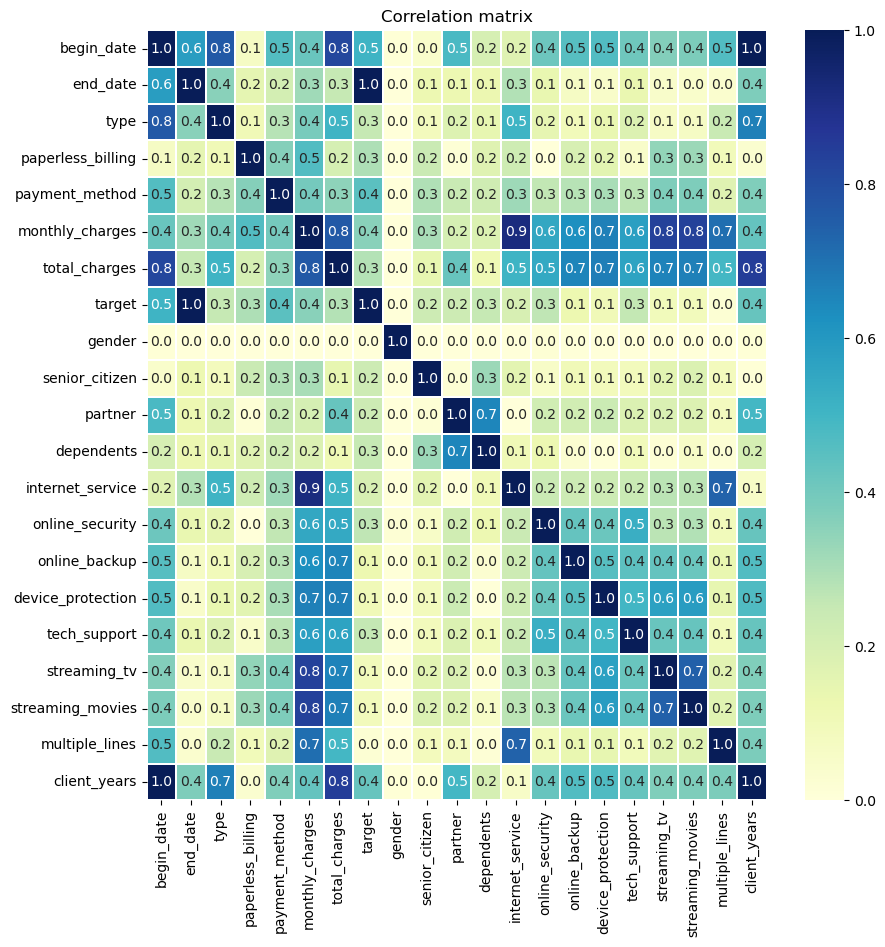

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(phik_overview , annot=True, fmt='.1f', linewidths=0.01, ax=ax, cmap="YlGnBu")
plt.title('Correlation matrix')
plt.show()

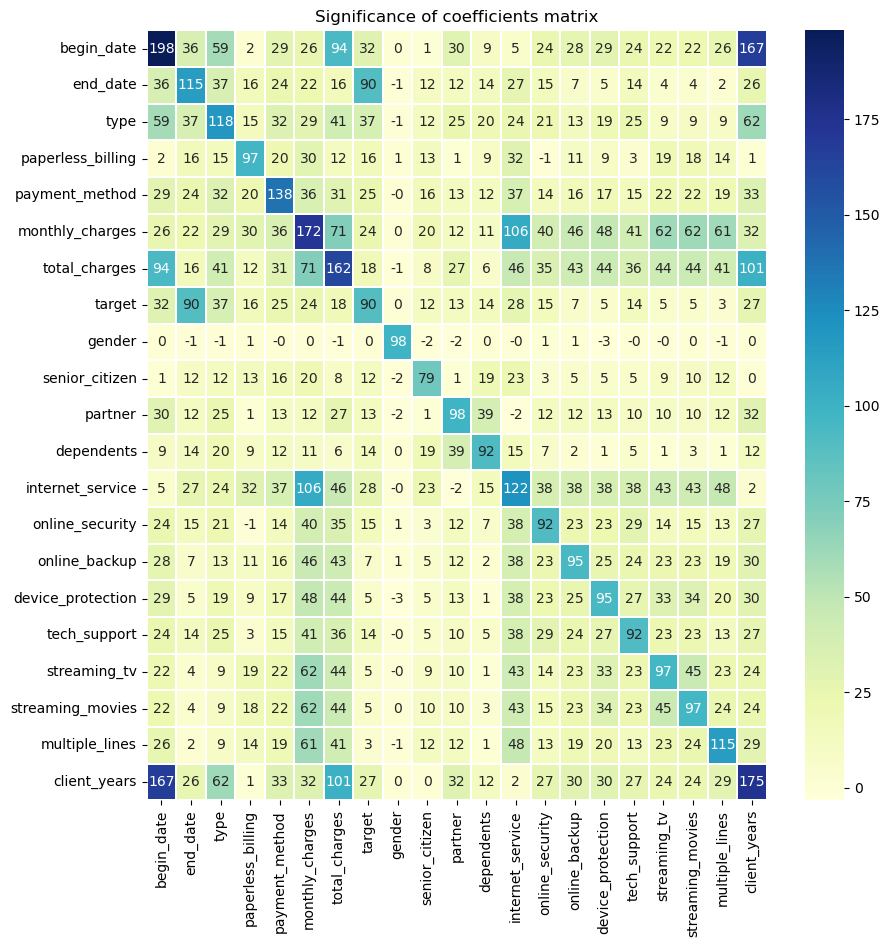

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(significance_overview , annot=True, fmt='.0f', linewidths=0.01, ax=ax, cmap="YlGnBu")
plt.title('Significance of coefficients matrix')
plt.show()

* Рассмотрим как меняется total_charges в зависимости от других категориальных переменных.
* На графиках не видно какого-то сильного отличия между оптоволкном и дсл, бокслоты пересекаются
* С точки зрения наличия телефона видно, что наличие нескольких линий повышает обшие выплаты (бокплоты практически не пересекаются)

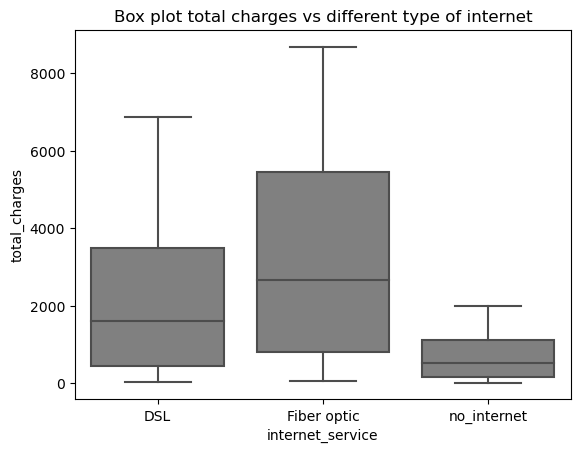

In [36]:
sns.boxplot(x = df.internet_service, y = df.total_charges, color='gray')
plt.title('Box plot total charges vs different type of internet')
plt.show()

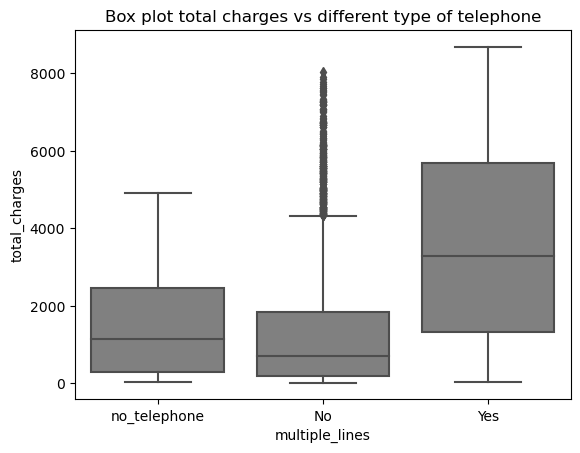

In [37]:
sns.boxplot(x = df.multiple_lines, y = df.total_charges, color='gray')
plt.title('Box plot total charges vs different type of telephone')
plt.show()

**Зависимость таргета от типа сервиса телефона или интернета**:
- Мы видим, что в среднем таргет не сильно меняется от наличия телефона или нескольких линий (около 0.25)
- **Однако таргет для оптоволокна сильно выше, чем по датасету 0.42**, возможно это говорит о том, что качество оптоволокна не лучшее, и компании следуют на это обратить внимание

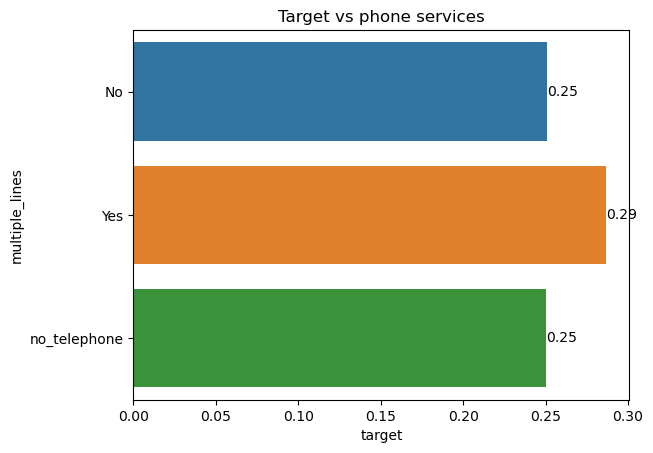

In [38]:
ax = sns.barplot(x=df.groupby('multiple_lines').target.mean(), y=df.groupby('multiple_lines').target.mean().index)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')
plt.title('Target vs phone services')
plt.show()

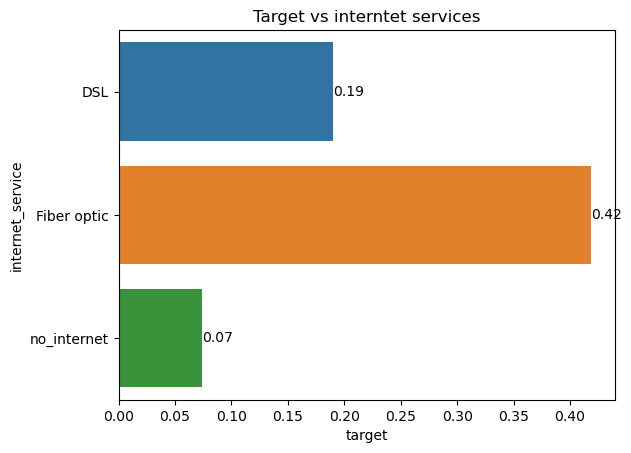

In [39]:
ax = sns.barplot(x=df.groupby('internet_service').target.mean(), y=df.groupby('internet_service').target.mean().index)
for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')
plt.title('Target vs interntet services')
plt.show()

**Портрет уходящего клиента**

В отличие от тех, кто остается:
* Они платят выше помесячную плату (около 80 медиана против 65)
* У них меньше общие выплаты более чем в два раза по медиане (706 против 1689)
* Не имеют супруга
* Используют оптоволкно
* Используют несколько линий телефона
* Являются клиентом меньше 1 года

* Гендер не показал стат значимости коэфф, поэтому здесь не указываем

In [40]:
df.groupby('target').agg(pd.Series.mode)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_years
target,,,,,,,,,,,,,,,,,,,,
0,2014-02-01,No,Month-to-month,Yes,Electronic check,20.05,19.75,Male,No,Yes,No,DSL,No,No,No,No,No,No,No,5.917808
1,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,74.40,20.20,Female,No,No,No,Fiber optic,No,No,No,No,No,No,Yes,0.334247


In [41]:
df.groupby('target').agg(pd.Series.median)

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_15144\1320272654.py:1: FutureWarning: ['end_date', 'type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('target').agg(pd.Series.median)


,begin_date,monthly_charges,total_charges,client_years
target,,,,
0,2016-12-01,64.55,1688.900,3.084932
1,2019-02-01,79.65,706.725,0.915068


### Выводы из первичного анализа данных
- Мы объединили 4 предоставленные нам таблицы, заполнили пропуски и обработали данные, изменив их тип. В целом в данных каких-то больших технических проблем нет.
- Мы добавили таргет = 1, если клиент ушел. Имеет дисбаланс классов, порядка 27% клиентов прекратили контракты
    - С точки зрения изначальных наблюдений мы отмечаем следующее:
        - Мы видим, что в среднем таргет не сильно меняется от наличия телефона или нескольких линий (около 0.25)
        - **Однако таргет для оптоволокна сильно выше, чем по датасету 0.42**, возможно это говорит о том, что качество оптоволокна не лучшее, и компании следуют на это обратить внимание
        - **Мы отмечаем слабую отрицательную корреляцию между таргетом и общей суммой** и тем, сколько лет клиент пробыл в компании. Также эти две величины сильно коррелируют между собой. Клиенты, которые находятся дольше в сети, больше денег платят в общем и реже уходят.

**Портрет уходящего клиента**

* Они платят выше помесячную плату (около 80 медиана против 65)
* У них меньше общие выплаты более чем в два раза по медиане (706 против 1689)
* Не имеют супруга
* Используют оптоволкно
* Используют несколько линий телефона
* Являются клиентом меньше 1 года
        
**Рекоммендация по данным**:
- Данные по расторжениям контрактов только за последние 4 месяца. Проверить, что там нет ошибки и расширить выборку за большое количестов месяцев
- Также данные по клиентам какие-то скудные - нужно бы добавить как минимум еще возраст клиента, возможно, его адрес, так как если клиент использует телефон, может коннекшен в его районе не такой хороший и люди уходят из определенного района

## Train-test split

* **Про балансировку классов**:
    - В нашем случае имеется дисбаланс классов но не ярко выраженный. Кроме того метрикой является ROC-AUC, эта метрика чувствительна к дисбалансу класса в том смысле, что угадывание верных значений более редкого класса имеет большой вес, в отличие от accuracy, где вес одинаковый. Поэтому выбор метрики считаем удачным в этом упражнении.
    - Мы также будем использовать встроенные методы балансировки в алгоритмах с помощью class weights

In [42]:
df_features = df.drop(['end_date', 'begin_date', 'target'], axis=1)
df_target = df['target']
features_train, features_test, target_train, target_test = train_test_split(df_features, df_target,
                                                    test_size=0.25,
                                                    random_state=270123,
                                                    stratify=df.target)

## Feature engineering and multicollinearity adjustment

* Добавляем несколько новых признаков:

    1. `monthly_total_ratio` Сколько клиент платит в месяц  / среднее в месяц от общего кол-ва
        * Клиенты для которых это значение ниже, докупают дополнительных услуг и скорее всего реже закрывают контракты
    2. `total_per_person` сколько всего потрачено / оценку количества семьи (1 - один, 2 - партнер, 3 - партнер и иждивенец)
        * Данная оценка лучше показывает реальные траты на одного человека по контракту. Интернетом и телефоном пользуется все домохозяйство
    3. `monthly_per_person` оплата за месяц / оценку количества семьи (1 - один, 2 - партнер, 3 - партнер и иждивенец)
        * Такая же  логика как выше, но за месяц
    4. `last_year_payment` Сколько клиент заплатил за последние 12 месяцев из расчета полной оплаты
        * Те кто платил больше за последние 12 месяцев - активнее пользовались услугами компании. Это статистика помогает различать между старыми клиентами (активные в далеком прошлом или сейчас)

In [43]:
def make_features(df):
    #Сколько клиент платит в месяц  / среднее в месяц от общего кол-ва
    df.loc[df.client_years==0, 'monthly_total_ratio'] = 1
    df.loc[df.client_years!=0, 'monthly_total_ratio'] = df.monthly_charges / df.total_charges / df.client_years

    #Сколько уходит на одного человека на семью
    df['total_per_person'] = df['total_charges'] / (1 + (df['partner'] == 'Yes') + (df['dependents'] == 'Yes'))

    #Сколько уходит на одного человека на семью
    df['monthly_per_person'] = df['monthly_charges'] / (1 + (df['partner'] == 'Yes') + (df['dependents'] == 'Yes'))
    
    #Сколько клиент заплатил за последние 12 месяцев из расчета полной оплаты
    df.loc[df.client_years < 1, 'last_year_payment'] = df.total_charges
    df.loc[df.client_years >=1, 'last_year_payment'] = df.total_charges / df.client_years
    
    num_columns = df.select_dtypes('number').columns
    
    return df[num_columns]

In [44]:
#storing column names
num_transform_columns = make_features(features_train.copy()).columns

**Проверка на мультиколлинарность**:

* Используем метод Variance Inflation Factor, считаем VIF для каждого числового предиктора в модели.

Мы используем следующую конвенциональную интерпретацию:

 - VIF = 1: Нет корреляции между предиктором и другими признаками
 - VIF between 1 and 5: есть небольшая корреляция между предиктором и другими признаками
 - VIF > 5: Сильная корреляция между предиктором и другими признаками

In [45]:
def calc_vif(df, columns):
    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['feature'] = columns
    #calculate VIF for each predictor variable 
    vif_df['VIF'] = [variance_inflation_factor(df[columns], i) for i in range(df[columns].shape[1])]

    #view VIF for each predictor variable 
    print(vif_df)

In [46]:
num_columns_original = ['monthly_charges', 'total_charges', 'client_years']
calc_vif(df,['monthly_charges', 'total_charges', 'client_years'])

           feature       VIF
0  monthly_charges  3.373950
1    total_charges  8.080282
2     client_years  6.447487


* Мы видим, что total_charges скорее всего коррелирован с другими переменными в оригинальном датасете

In [47]:
calc_vif(df,['monthly_charges', 'client_years'])

           feature       VIF
0  monthly_charges  2.664967
1     client_years  2.664967


* У нас остается средней степени корреляция, проверим новый датасет

In [ ]:
make_features(features_train.copy()).columns

In [49]:
cols = ['monthly_charges', 'total_charges', 'client_years',
       'monthly_total_ratio', 'total_per_person', 'monthly_per_person',
       'last_year_payment']
calc_vif(make_features(features_train.copy()), cols)

               feature        VIF
0      monthly_charges  55.244470
1        total_charges  29.302566
2         client_years   6.529527
3  monthly_total_ratio   1.749510
4     total_per_person  20.626563
5   monthly_per_person  25.765977
6    last_year_payment  28.025640


* После добавления новых признаков ситуация ухудшилась, мы уберем сверху более проблематичные

In [50]:
selected_columns = ['client_years','monthly_total_ratio', 'monthly_per_person']

calc_vif(make_features(features_train.copy()), selected_columns)

               feature       VIF
0         client_years  1.865564
1  monthly_total_ratio  1.145447
2   monthly_per_person  2.023909


* Как мы видим, чтобы полностью избавиться от мультиколлинеарности, нужно количество признаков порезать до 2-х и ситуация исправляется 

In [51]:
selected_columns = ['client_years','monthly_total_ratio']

calc_vif(make_features(features_train.copy()), selected_columns)

               feature       VIF
0         client_years  1.000371
1  monthly_total_ratio  1.000371


* Мы отмечаем, проблему мультиколлинеарности данных в датасете, в первую очередь она связана с тем, что в оригинальном датасете имеется всего 2 числовых переменных (оплата полная и за месяц), которые между собой очевидно связаны.
* Мы создали несколько признаков, но все они были коррелированы, после удаления признака мы остались с двумя, которые показывают низкую степерь корреляции.
* Итоговые признаки это время (годы) с начала контракта и отношения месячной выплаты к итоговой, `client_years`, `monthly_total_ratio`.

## Encoding and creating preprocessing pipeline

* Мы создаем прероцессинг, он строится из
    1. Для числовых признаков:
        1. Создание признаков
        2. Стандарт скейлер
    2. Для категориальных признаков:
         1. Для кодирования признаков мы будем использовать One-hot, так как у нас не так много категорий каждой категориальной переменной (максимум 3)

In [52]:
def make_features(df):
    #Сколько клиент платит в месяц  / среднее в месяц от общего кол-ва
    df.loc[df.client_years==0, 'monthly_total_ratio'] = 1
    df.loc[df.client_years!=0, 'monthly_total_ratio'] = df.monthly_charges / df.total_charges / df.client_years
    
    num_columns = ['client_years' ,'monthly_total_ratio']
    
    return df[num_columns]

In [53]:
#storing numeric columns
num_columns = ['client_years' ,'monthly_total_ratio']

#storing cat columns
cat_columns = features_train.select_dtypes(object).columns

#making features
feature_engineering = ColumnTransformer([
        ('make_features',  FunctionTransformer(make_features, validate=False), features_train.columns)
])

#adding scaler and wrapping into a pipeline
num_pipeline = Pipeline(steps =[
    ('feature_engineering', feature_engineering),
    ('scaler', StandardScaler())
])

In [54]:
#combining with OHE, making a preprocessor
preprocessor = ColumnTransformer([
     ('num_pipeline',  num_pipeline, features_train.columns),
     ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), cat_columns)
])

In [55]:
#code check
preprocessor.fit(features_train)

#storing column names
cols = num_columns
cols.extend(list(preprocessor.named_transformers_['ohe'].get_feature_names_out()))

pd.DataFrame(preprocessor.transform(features_train), columns = cols)

,client_years,monthly_total_ratio,type_Month-to-month,type_One year,type_Two year,paperless_billing_Yes,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_DSL,internet_service_Fiber optic,internet_service_no_internet,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_No,multiple_lines_Yes,multiple_lines_no_telephone
0,0.123825,-0.329125,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.156088,-0.018747,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1.117047,-0.332731,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
3,1.574935,-0.333290,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
4,-0.372107,-0.323281,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5259,0.954001,-0.332454,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5260,-0.204985,-0.326185,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5261,-0.493033,-0.319568,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
5262,1.409172,-0.333049,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


## Models fit

* Мы выбрали три модели классификации:
    1. Логистическая регрессия
    2. Случайный лес
    3. Градиентный бустинг (катбуст)
* С балансом классов мы работаем с помощью встроенных методов внутри моделей для балансировки
    * Для регрессии и случайного леса выбор балансировки показывает улучшение результата
    * Для катбуста балансировка не потребовалась, опять же учитываем особенности метрики
* Метрикой оценки был ROC-AUC, эта метрика чувствительна к дисбалансу класса в том смысле, что угадывание верных значений более редкого класса имеет большой вес, в отличие от accuracy, где вес одинаковый. Поэтому выбор метрики считаем удачным в этом упражнении.
* Калибровку гиперпараметров делаем с помощью gridsearch и кросс-валидации на 5 фолдах

### Logistic regression

In [56]:
%%time

parameters = {
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C':[1, 3.5, 4, 4.5, 5, 6, 10],
    'logisticregression__solver': ['lbfgs', 'liblinear']
}

pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
    
clf = GridSearchCV(pipe,parameters, cv=5, scoring='roc_auc', n_jobs=-1)
clf.fit(features_train.reset_index(drop=True), target_train.reset_index(drop=True))

print("Best cross-validation model: {}".format(clf.best_params_))
print("Best cross-validation score: {:.3f}".format(clf.best_score_))

#accuracy score on the whole train set (not CV) for reference
logistic_model = clf.best_estimator_
logistic_model.fit(features_train, target_train)
logistic_accuracy = accuracy_score(target_train, logistic_model.predict(features_train))
print(f'Train accuracy score: {logistic_accuracy:.3f}')

Best cross-validation model: {'logisticregression__C': 3.5, 'logisticregression__class_weight': 'balanced', 'logisticregression__solver': 'lbfgs'}
Best cross-validation score: 0.851
Train accuracy score: 0.753
Wall time: 2.79 s


In [57]:
results = pd.DataFrame([clf.best_score_], index=['ROC-AUC'], columns=['Logistic'])
results

,Logistic
ROC-AUC,0.851429


* Логистическая регрессия показала результат лучше необходимого трешолда 0.85

### Random forest

In [58]:
%%time

parameters = {
    'randomforestclassifier__n_estimators': [200, 300, 400],
    'randomforestclassifier__max_depth' : [10, 28,29,30,31,50],
    'randomforestclassifier__class_weight' : [None,'balanced']
}

pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state=270123))
    
clf = GridSearchCV(pipe,parameters, cv=5, scoring='roc_auc', n_jobs=-1)
clf.fit(features_train.reset_index(drop=True), target_train.reset_index(drop=True))

print("Best cross-validation model: {}".format(clf.best_params_))
print("Best cross-validation score: {:.3f}".format(clf.best_score_))

#accuracy score on the whole train set (not CV) for reference
forest_model = clf.best_estimator_
forest_model.fit(features_train, target_train)

forest_accuracy = accuracy_score(target_train, forest_model.predict(features_train))
print(f'Train accuracy score: {forest_accuracy:.3f}')

Best cross-validation model: {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 400}
Best cross-validation score: 0.880
Train accuracy score: 0.887
Wall time: 17min 5s


In [59]:
results['RandomForest'] = [clf.best_score_]
results

,Logistic,RandomForest
ROC-AUC,0.851429,0.879797


* Случайный лес показал результат лучше трешолда 0.85, а также лучше логистической регресии

### Catboost

In [62]:
%%time

parameters = {
    'catboostclassifier__depth'         : [3,4,5],
    'catboostclassifier__learning_rate' : [0.04, 0.06, 0.07],
    'catboostclassifier__iterations'    : [300, 400, 700],
    'catboostclassifier__auto_class_weights': ['None', 'Balanced', 'SqrtBalanced']
                 }

pipe = make_pipeline(preprocessor, CatBoostClassifier(random_seed=270123, verbose=False))
    
clf = GridSearchCV(pipe,parameters, cv=5, scoring='roc_auc', n_jobs=-1)
clf.fit(features_train.reset_index(drop=True), target_train.reset_index(drop=True))

print("Best cross-validation score: {:.3f}".format(clf.best_score_))

#accuracy score on the whole train set (not CV) for reference
cat_model = clf.best_estimator_
cat_model.fit(features_train, target_train)

cat_accuracy = accuracy_score(target_train, cat_model.predict(features_train))
print(f'Train accuracy score: {cat_accuracy:.3f}')

Best cross-validation score: 0.962
Train accuracy score: 0.960
Wall time: 2min 56s


In [63]:
clf.best_params_

{'catboostclassifier__auto_class_weights': 'SqrtBalanced',
 'catboostclassifier__depth': 4,
 'catboostclassifier__iterations': 700,
 'catboostclassifier__learning_rate': 0.07}

In [64]:
results['CatBoost'] = [clf.best_score_]
results

,Logistic,RandomForest,CatBoost
ROC-AUC,0.851429,0.879797,0.961608


### Выводы из обучения модели

* Мы обучили и провели кросс-валидацию трех моделей:
    1. Логистическая регрессия
    2. Случайный лес
    3. Градиентный бустинг
* В логистической регресии мы использовали регуляризацию параметров как один из методов борьбы с мультироколлинеарностью предикторов. Однако, далее мы не стали улучшать модель, подбирая признаки, так как модели на основе деревьем показали результаты лучше
* Градиентный бустинг показал результат лучше всего 0.96 ROC-AUC на кросс-валидации, что выше необходимого трешолда 0.85

## Feature importances

* Проанализируем значимость признаков с помощью встроенных методов катбуст, который работает на основе premutation и отслеживает изменение функции потерь. 
* Интрепретация может хромать ввиду мультиколлениарности признаков.

Топ 3 признака:
- `client_years` как давно был заключен контракт. Как мы видели ранее - чем дольше клиент сохраняет котракт, тем реже он выходит из него. Так как у нас данные по выходам из котракта за последние 4 месяца, считаем, что это значение примерно равно сколько всего клиент пробыл клиентом
- `last_year_payment` сколько клиент заплатил за последний год. Предполагаем, что те кто платил мало за последний год более вероятно уходят из контракта
- `monthly_total_ratio` отношение регулярной оплаты за месяц, к общей оплаты за месяц. Здесь мы считаем, что если клиент добирает больше дополнительных услуг, то у него меньше мотивация закрывать контракт.


Другие значимые признаки:
- `monthly_median_ratio` - во сколько раз клиент платит больше, чем медиана по его контрактам. Знак влияния сложно угадать из данных, так как клиенты могут уходить из-за того, что они слишком много платят.
-  `type_month_to_month` - ежемесячные контракты легче разорвать


Незначительные признаки:
- `multiple_lines` - наличие телефона и его отсуствие, наличие линий не показали значимости. Это мы видели в первичном анализе и подтвердили моделью
- `partner`, `dependents` - наличие семьи не показало значимости, однако возможно этот фактор зашел в модель через предикатор `total_per_person`, `monthly_per_person` которые показали значимость.

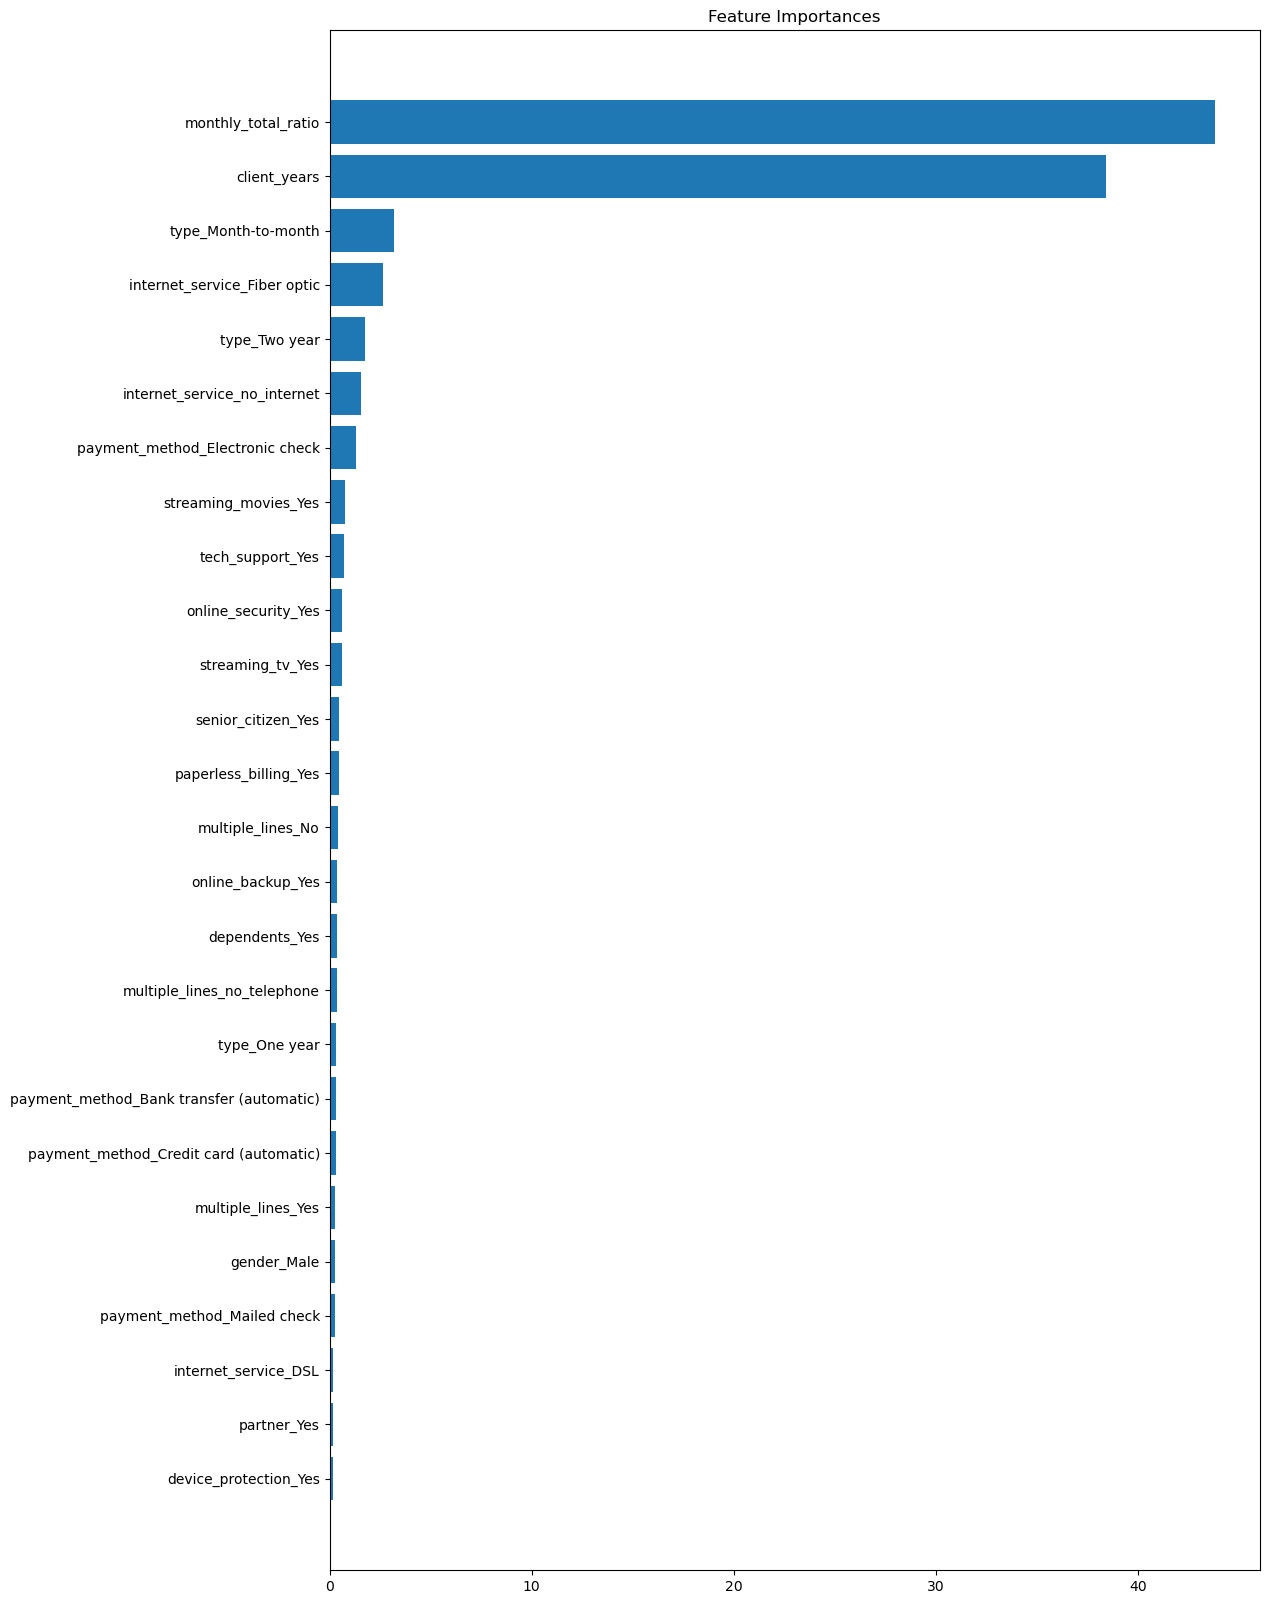

In [65]:
feature_importance = cat_model._final_estimator.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cols)[sorted_idx])
plt.title('Feature Importances')
plt.show()

### ROC-AUC graph

* Построим график ROC-AUC для наглядности
* Для наглядности, мы  так же добавим confusion matrix

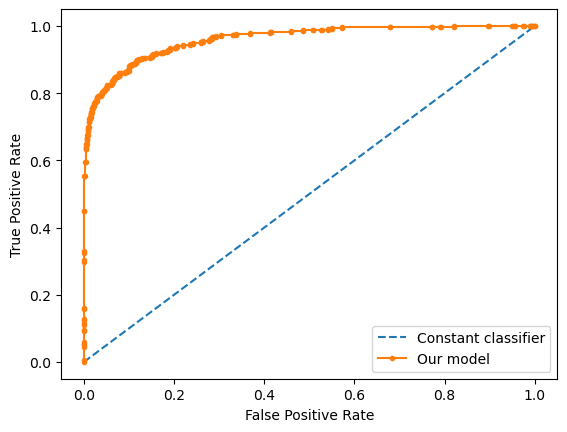

In [81]:

#constant classifier
random_probs = np.zeros(len(target_test))

# predict probabilities
probas = cat_model.predict_proba(features_test)[:,1]

# calculate roc curves
r_fpr, r_tpr, _ = roc_curve(target_test, random_probs)
c_fpr, c_tpr, _ = roc_curve(target_test, probas)
# plot the roc curve for the model
pyplot.plot(r_fpr, r_tpr, linestyle='--', label='Constant classifier')
pyplot.plot(c_fpr, c_tpr, marker='.', label='Our model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [87]:
prediction = cat_model.predict(features_test)

In [88]:
confusion_matrix(target_test, cat_model.predict(features_test))

array([[1223,   65],
       [  83,  384]], dtype=int64)

In [97]:
## Accuracy
print(f'Accuracy score: {accuracy_score(target_test,prediction):.2f}')
## Precision
print(f'Precision score: {precision_score(target_test,prediction):.2f}')

## Recall
print(f'Recall score: {recall_score(target_test,prediction):.2f}')


## F1 Score
print(f'F1 score: {f1_score(target_test,prediction):.2f}')


Accuracy score: 0.92
Precision score: 0.86
Recall score: 0.82
F1 score: 0.84


* По матрице ошибок и дополнительным метрикам мы видим, что модель неплохо справляется как с precision так и recall, при этом precision выше, что значит модель особенно не ошибается в определении еденичных классов

* Наша рекоммендация для дальнейшей работы отобрать модель, которая оптимизирует метрику recall - если мы хотим найти именно всех клиентов, кто собирается разорвать контракт

## Предсказания на тестовой выборке

* На тестовой выборке результат 0.96, что выше проговой метрики и консистент с валидацией. Считаем модель успешной.
* Отличия могли произойти в результате неудачного случайного сэмплинга.

In [98]:
print(f'Test sample ROC-AUC: {roc_auc_score(target_test, cat_model.predict_proba(features_test)[:,1])}')

Test sample ROC-AUC: 0.960247449692101


## Общие выводы

**В этой работе мы проанализировали данные и разработали модель для «Ниединогоразрыва.ком», которая предсказывает какие клиенты вероятнее всего разорвут конктракт, и позволит маркетинговому отделу сфокусироваться на удержании этих клиентов**


**Что было сделано в работе:**

1. Первичный анализ данных
4. Создаем дополнительных признаков, которые помогли в предсказаниях
4. Обучение нескольких моделей и выбор лучшей модели по метрике ROC-AUC
7. Анализ важности признаков
8. Финальные выводы и рекомендации для компании


**Первичный анализ данных:**

- Мы объединили 4 предоставленные нам таблицы, заполнили пропуски и обработали данные, изменив их тип. В целом в данных каких-то больших технических проблем нет. Мы добавили таргет = 1, если клиент ушел. Имеет дисбаланс классов, порядка 27% клиентов прекратили контракты
    - Клиенты, которые находятся дольше в сети, больше денег платят в общем и реже уходят
    - Мы также видим, что в клиенты уходят скорее всего из-за плохого качества оптоволокнового соединения. Наличие или отсутствие телефона или нескольких линий не показали визуального влияния на уход клиентов.


**Выбор модели:**
* Мы обучили и провели кросс-валидацию трех моделей:
    1. Логистическая регрессия
    2. Случайный лес
    3. Градиентный бустинг
    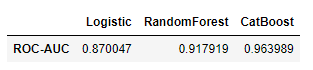
* Градиентный бустинг показал результат лучше всего 0.96 ROC-AUC на кросс-валидации, что выше необходимого трешолда 0.85
    * Балансировка классов не потребовалась, ввиду особенностей чувствительности ROC-AUC к дисбалансу
* На тестовой выборке результат оказался не хуже - 0.96, считаем, что модель хорошо отработала.


**Дальнейшая работа и рекомендации к данным:**
- Данные по расторжениям контрактов только за последние 4 месяца. Проверить, что там нет ошибки и расширить выборку за большое количестов месяцев
- Также данные по клиентам рекомендуем расширить и добавить как минимум еще возраст клиента, возможно, его адрес, так как если клиент использует телефон, может коннекшен в его районе не такой хороший и люди уходят из определенного района


**Мы разработали успешную модель для компании и важные выводы из анализа данных, которые помогут удержать клиентов и заработать денег. Дальнейшее исследование и улучшение модели возможно при получении дополнительных данных указанных выше**
